# Know Your Skew

# Packages

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Read and Prep Data

In [3]:
df_raw = pd.read_parquet(
    path = "etf_prices.parquet",
    engine = "pyarrow")

Count tickers to see which ones are worth dropping, let's just say we want 10 years worth of data

In [34]:
MINDAYS = 252 * 10

tickers1 = (df_raw.dropna()[
    ["variable", "value"]].
    groupby("variable").
    agg("count").
    query("value >= @MINDAYS").
    index.
    to_list())

Keep track of how many tickers we have

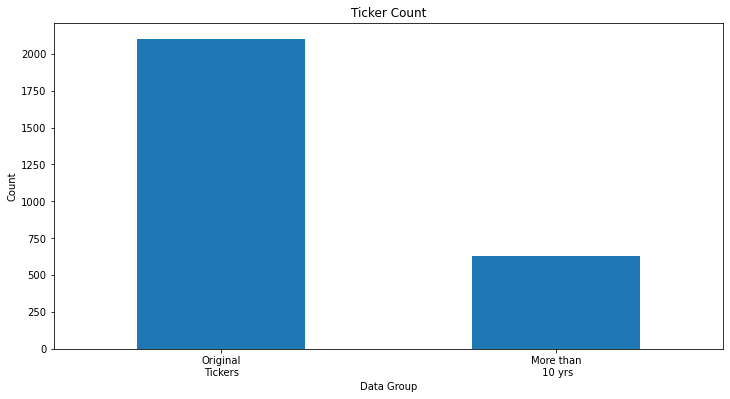

In [56]:
df_tickers = (pd.DataFrame({
    "Data Group": ["Original\nTickers", "More than\n 10 yrs"],
    "Data Count": [len(df_raw.variable.drop_duplicates()), len(tickers1)]}).
    set_index("Data Group"))

(df_tickers.plot(
    kind = "bar", 
    rot = 360,
    legend = False,
    ylabel = "Count",
    title = "Ticker Count",
    figsize = (12, 6)))

plt.show()

Let's look at our data and fix out some of the missing data

In [36]:
df_prep1 = (df_raw.query(
    "variable == @tickers1").
    pivot(index = "Date", columns = "variable", values = "value").
    dropna().
    reset_index().
    melt(id_vars = "Date"))

# Some Exploratory Analysis

Let's calculate some statistics and look at cumulative returns as well

In [80]:
def _calc_rtn(df: pd.DataFrame) -> pd.DataFrame:
    return(df.sort_values(
        "Date").
        assign(
            rtn = lambda x: x.value.pct_change(),
            cum_rtn = lambda x: np.cumprod(1 + x.rtn) - 1))

df_rtn = (df_prep1.groupby(
    "variable", group_keys = False).
    apply(_calc_rtn))

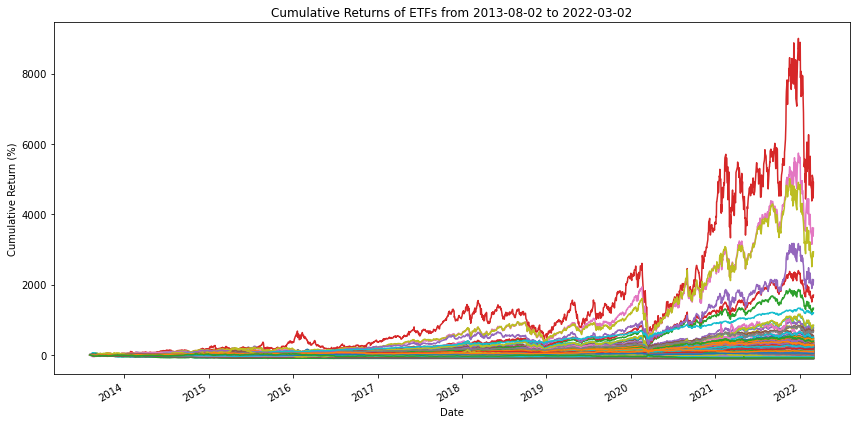

In [81]:
(df_rtn[
    ["Date", "variable", "cum_rtn"]].
    assign(cum_rtn = lambda x: x.cum_rtn * 100).
    pivot(index = "Date", columns = "variable", values = "cum_rtn").
    plot(
        legend = False,
        figsize = (12, 6),
        ylabel = "Cumulative Return (%)",
        title = "Cumulative Returns of ETFs from {} to {}".format(
            df_rtn.Date.min().date(),
            df_rtn.Date.max().date())))

plt.tight_layout()
plt.show()

It appears we have some unusual returns and we'll drop them with z-scores

In [57]:
tickers2 = (df_rtn.query(
    "Date == Date.max()")
    [["variable", "cum_rtn"]].
    assign(z_score = lambda x: np.abs((x.cum_rtn - x.cum_rtn.mean()) / x.cum_rtn.std())).
    query("z_score < 2").
    variable.
    to_list())

In [65]:
df_tickers = (df_tickers.reset_index().append(
    pd.DataFrame({
        "Data Group": ["Cum Rtn\n z-score drop"],
        "Data Count": [len(tickers2)]})).
    set_index("Data Group"))

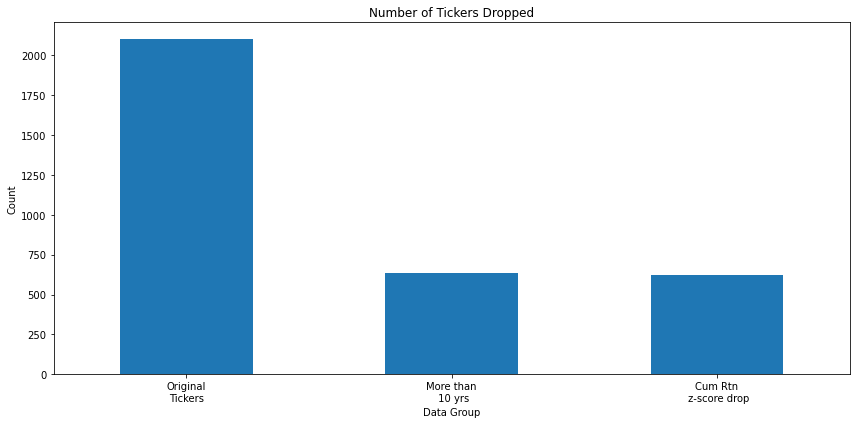

In [69]:
df_tickers.plot(
    kind = "bar",
    rot = 360,
    title = "Number of Tickers Dropped",
    ylabel = "Count",
    legend = False,
    figsize = (12, 6))

plt.tight_layout()

Let's just look over and check the cumulative returns after the drop

In [83]:
df_rtn = (df_rtn.query(
    "variable == @tickers2"))

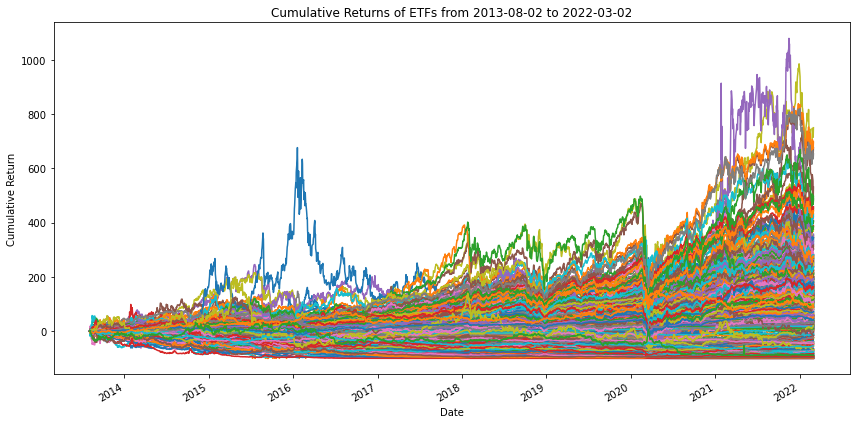

In [84]:
(df_rtn[
    ["Date", "variable", "cum_rtn"]].
    assign(cum_rtn = lambda x: x.cum_rtn * 100).
    pivot(index = "Date", columns = "variable", values = "cum_rtn").
    plot(
        legend = False,
        figsize = (12, 6),
        ylabel = "Cumulative Return",
        title = "Cumulative Returns of ETFs from {} to {}".format(
            df_rtn.Date.min().date(),
            df_rtn.Date.max().date())))

plt.tight_layout()
plt.show()

Now calculate and analyze moments

In [98]:
df_moments = (df_rtn[
    ["variable", "rtn"]].
    groupby("variable").
    agg(["mean", "std", "skew"])
    ["rtn"])

array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

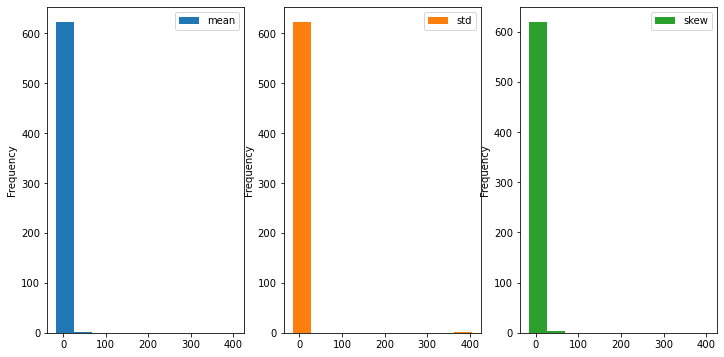

In [100]:
(df_moments.plot(
    kind = "hist",
    subplots = True,
    layout = (1, 3),
    figsize = (12, 6),
    ))